In [55]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load data
columns = ['q'+ str(i) for i in range(10)] + ['Age', 'Gender', 'Ethnicity', 'Born', 'Family', 'Who', 'Country', 'Used', 'Group','Screening', 'Score']
data=pd.read_csv('autism_data.arff', sep=',', header=None)
data.columns = columns
data = data.replace({'NO':0, 'YES':1})
data.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,Gender,Ethnicity,Born,Family,Who,Country,Used,Group,Screening,Score
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,0
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,0
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,1
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,0
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2,'18 and more',?,0


In [66]:
# Create X and Y data
num_feat = 7
X = data.iloc[:,:num_feat]
Y = data.iloc[:,-1]
Z = data.iloc[:,[i for i in range(num_feat)] + [20]]
print(X.shape, Y.shape, Z.shape)

(704, 7) (704,) (704, 8)


In [67]:
# Map to probabilities
probs = []
for i in range(X.shape[0]):
    val = X.iloc[i]
    Z_sel = Z.query(" and ".join(["q" + str(k) +"==" + str(val[k]) for k in range(len(val))]))
    probs.append(Z_sel['Score'].mean())    
probs = np.array(probs)
print(np.unique(probs), probs.shape)

[0.         0.09090909 0.125      0.14285714 0.2        0.25
 0.27272727 0.33333333 0.5        0.66666667 0.75       0.8
 0.875      0.90909091 1.        ] (704,)


In [75]:
num_feat = 8
X['qe'] = 1

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split( X.values, probs, test_size=0.15, random_state=42)
# scale probs to [-1,1]
#scaler = MinMaxScaler((-1,1))
#y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
#y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()
y_train_scaled = y_train
y_test_scaled = y_test

In [77]:
import pennylane as qml
import tensorflow as tf

nqbits = num_feat
depth=10

dev = qml.device("default.qubit", wires=nqbits)
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.BasisEmbedding(inputs, wires=range(nqbits)) 
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqbits))
    return [qml.expval(qml.pauli.string_to_pauli_word('Z'*nqbits))]#qml.probs(wires=list(range(nqbits)))##[qml.expval(qml.PauliZ(wires=i)) for i in range(nqbits)]

weight_shapes = {"weights": (depth, nqbits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1)#2**nqbits)#nqbits)#1)
clayer = tf.keras.layers.Dense(1, activation="relu")

# specify inputs
inputs = tf.keras.Input(shape=(nqbits,))
x = qlayer(inputs)
outputs = clayer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(opt, loss='mse')

x = X.values[:2,:]
print(model(x))
print(qlayer(x))
model.summary()


tf.Tensor(
[[0.88797235]
 [0.        ]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[-0.75017514]
 [ 0.72497483]], shape=(2, 1), dtype=float64)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 8)]               0         
                                                                 
 keras_layer_14 (KerasLayer)  (None, 1)                240       
                                                                 
 dense_14 (Dense)            (None, 1)                 2         
                                                                 
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [78]:
import pennylane as qml
import tensorflow as tf

nqbits = int(np.log2(num_feat))
depth=10

dev = qml.device("default.qubit", wires=nqbits)
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AmplitudeEmbedding(inputs, wires=range(nqbits), normalize=True) 
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqbits))
    return qml.probs(wires=list(range(nqbits)))#qml.probs(wires=list(range(nqbits)))##[qml.expval(qml.PauliZ(wires=i)) for i in range(nqbits)]

weight_shapes = {"weights": (depth, nqbits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2**nqbits)#nqbits)#1)
clayer = tf.keras.layers.Dense(1, activation="relu")

# specify inputs
inputs = tf.keras.Input(shape=(2**nqbits,))
x = qlayer(inputs)
outputs = clayer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.02)
model.compile(opt, loss='mse')

x = X.values[:2,:]
print(model(x))
model.summary()


tf.Tensor(
[[0.43375275]
 [0.34312472]], shape=(2, 1), dtype=float32)
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 8)]               0         
                                                                 
 keras_layer_15 (KerasLayer)  (None, 8)                90        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


(<Figure size 500x400 with 1 Axes>, <Axes: >)


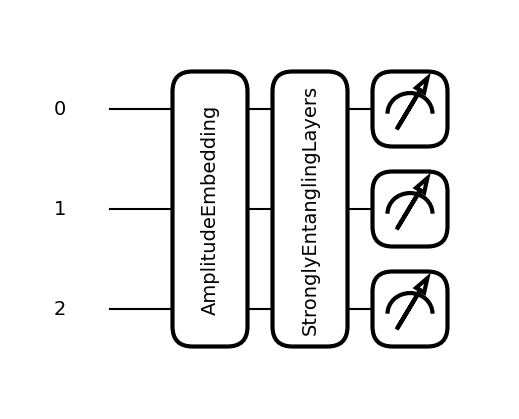

In [79]:
# Draw model
rng = np.random.default_rng(seed=42)
shape_weights = qml.templates.StronglyEntanglingLayers.shape(n_wires=nqbits, n_layers=1)
print(qml.draw_mpl(qnode)(X.values[0], rng.random(shape_weights)))

In [ ]:
history = model.fit(X_train, y_train_scaled,validation_split=0.1, epochs=15,batch_size=100)

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [87]:
y_hat = model.predict(X_test)
y_hat.shape

4/4 [==============================] - 24s 6s/step


(106, 1)

In [88]:
with open('predictions_QNN_7_amplitude.npy', 'wb') as f:
    np.save(f,y_hat)

with open('y_test_QNN_7_amplitude.npy', 'wb') as f:
    np.save(f,y_test_scaled)

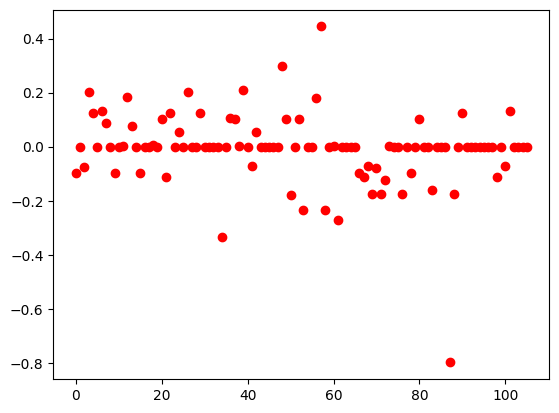

In [89]:
plt.plot(y_hat.flatten() - y_test_scaled, 'o', color='red')


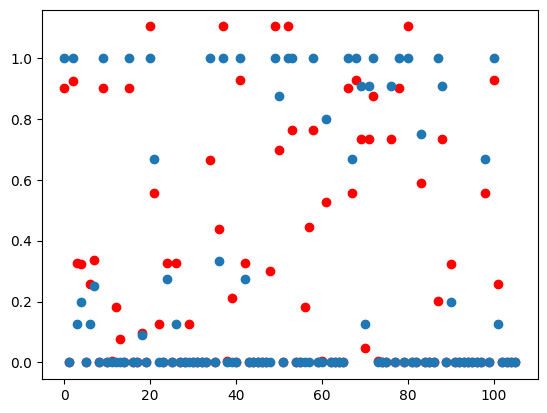

In [90]:
plt.plot(y_hat, 'o', color='red')
plt.plot(y_test_scaled, 'o')